<h1 align = 'center'> Neural Networks Demystified </h1>
<h2 align = 'center'> Part 5: Numerical Gradient Checking </h2>


<h4 align = 'center' > @stephencwelch </h4>

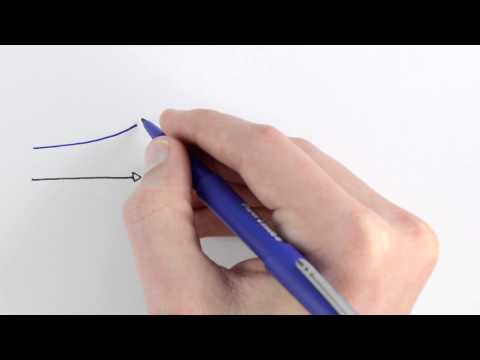

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('pHMzNW8Agq4')

Last time, we did a bunch of calculus to find the rate of change of our cost, J, with respect to our parameters, W. Although each calculus step was pretty straight forward, it’s still easy to make mistakes. What’s worse, is that our network doesn’t have a good way to tell us that it’s broken – code with incorrectly implemented gradients may appear to be functioning just fine.

This is the most nefarious kind of error when building complex systems. Big, in-your-face errors suck initially, but it’s clear that you must fix this error for your work to succeed. More subtle errors can be more troublesome because they hide in your code and steal hours of your time, slowly degrading performance, while you wonder what the problem is. 

A good solution here is to test the gradient computation part of our code, just as developer would unit test new portions of their code. We’ll combine a simple understanding of the derivative with some mild cleverness to perform numerical gradient checking. If our code passes this test, we can be quite confident that we have computed and coded up our gradients correctly. 

To get started, let’s quickly review derivatives. Derivates tell us the slope, or how steep a function is. Once you’re familiar with calculus, it’s easy to take for granted the inner workings of the derivative - we just accept that the derivative of x^2 is 2x by the power rule. However, depending on how mean your calculus teacher was, you may have spent months not being taught the power rule, and instead required to compute derivatives using the definition. Taking derivatives this way is a bit tedious, but still important - it provides us a deeper understanding of what a derivative is, and it’s going to help us solve our current problem. 

The definition of the derivative is really a glorified slope formula. The numerator gives us the change in y values, while the denominator is convenient way to express the change in x values. By including the limit, we are applying the slope formula across an infinitely small region – it’s like zooming in on our function, until it becomes linear. 



The definition tells us to zoom in until our x distance is infinitely small, but computers can’t really handle infinitely small numbers, especially when they’re in the bottom parts of fractions - if we try to plug in something too small, we will quickly lose precision. The good news here is that if we plug in something reasonable small, we can still get surprisingly good numerical estimates of the derivative. 

We’ll modify our approach slightly by picking a point in the middle of the interval we would like to test, and call the distance we move in each direction epsilon. 

Let’s test our method with a simple function, x squared. We’ll choose a reasonable small value for epsilon, and compute the slope of x^2 at a given point by finding the function value just above and just below our test point. We can then compare our result to our symbolic derivative 2x, at the test point. If the numbers match, we’re in business!

In [2]:
%pylab inline
#Import Code from previous videos:
from partFour import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
def f(x):
    return x**2

In [4]:
epsilon = 1e-4
x = 1.5

In [5]:
numericalGradient = (f(x+epsilon)- f(x-epsilon))/(2*epsilon)

In [6]:
numericalGradient, 2*x

(2.9999999999996696, 3.0)

Add helper functions to our neural network class: 

In [7]:
class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
        

We can use the same approach to numerically evaluate the gradient of our neural network. It’s a little more complicated this time, since we have 9 gradient values, and we’re interested in the gradient of our cost function. We’ll make things simpler by testing one gradient at a time. We’ll “perturb” each weight - adding epsilon to the current value and  computing the cost function, subtracting epsilon from the current value and computing the cost function, and then computing the slope between these two values. 

In [8]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 

We’ll repeat this process across all our weights, and when we’re done we’ll have a numerical gradient vector, with the same number of values as we have weights. It’s this vector we would like to compare to our official gradient calculation. We see that our vectors appear very similar, which is a good sign, but we need to quantify just how similar they are. 

In [9]:
NN = Neural_Network()

In [10]:
numgrad = computeNumericalGradient(NN, X, y)
numgrad

array([-0.01570145,  0.04553206,  0.02332193, -0.01261438,  0.02962221,
        0.02384717, -0.19123277, -0.24006099, -0.09635695])

In [11]:
grad = NN.computeGradients(X,y)
grad

array([-0.01570145,  0.04553206,  0.02332193, -0.01261438,  0.02962221,
        0.02384717, -0.19123277, -0.24006099, -0.09635695])

A nice way to do this is to divide the norm of the difference by the norm of the sum of the vectors we would like to compare. Typical results should be on the order of 10^-8 or less if you’ve computed your gradient correctly. 

In [12]:
norm(grad-numgrad)/norm(grad+numgrad)

2.7533413768397804e-10

And that’s it, we can now check our computations and eliminate gradient errors before they become a problem. Next time we’ll train our Neural Network. 